<a href="https://colab.research.google.com/github/senorred/IDS-Data-Challenges/blob/master/Norred_Liz_BC_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Liz Norred, DS SEA 20a, 
Data Challenge 1, Breast Cancer Malignancy Detection



In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


First, import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import csv as pandas dataframe, with ID as index. File was downloaded from the .gdoc file, and locally saved as .csv. Import the top row as header, the index column as index. Attempts to import the data in Int64 format failed because of the presence of unexpected strings indicating "null". Those values were included in the null dictionary. We can also find out how big the dataset is using df.shape.

---



In [5]:
df = pd.read_csv('/gdrive/My Drive/Insight Data Science/breast-cancer-wisconsin.csv', header = 0, index_col='Index', verbose=True, na_values={'No idea','#','?'}, keep_default_na=True, dtype='Int64')
print(df.shape)
print(df.dtypes)
df.head()

Tokenization took: 9.31 ms
Type conversion took: 105.48 ms
Parser memory cleanup took: 0.02 ms
(15855, 11)
ID                             Int64
Clump Thickness                Int64
Uniformity of Cell Size        Int64
Uniformity of Cell Shape       Int64
Marginal Adhesion              Int64
Single Epithelial Cell Size    Int64
Bare Nuclei                    Int64
Bland Chromatin                Int64
Normal Nucleoli                Int64
Mitoses                        Int64
Class                          Int64
dtype: object


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4


We know from the documentation that the dataset should have the following expected values for each feature: 


> Sample code number: id number 
Clump Thickness: 1 -10
Uniformity of Cell Size: 1 -10
Uniformity of Cell Shape: 1 -10
Marginal Adhesion: 1 -10
Single Epithelial Cell Size: 1 -10
Bare Nuclei: 1 -10
Bland Chromatin: 1 -10
Normal Nucleoli: 1 - 10
Mitoses: 1 - 10
Class: (2 for benign, 4 for malignant)

We have imported the data as integer class with <NA> values, but some of these values may be out of the expected range. A pairplot shows us that all columns have some data outside 1-10.



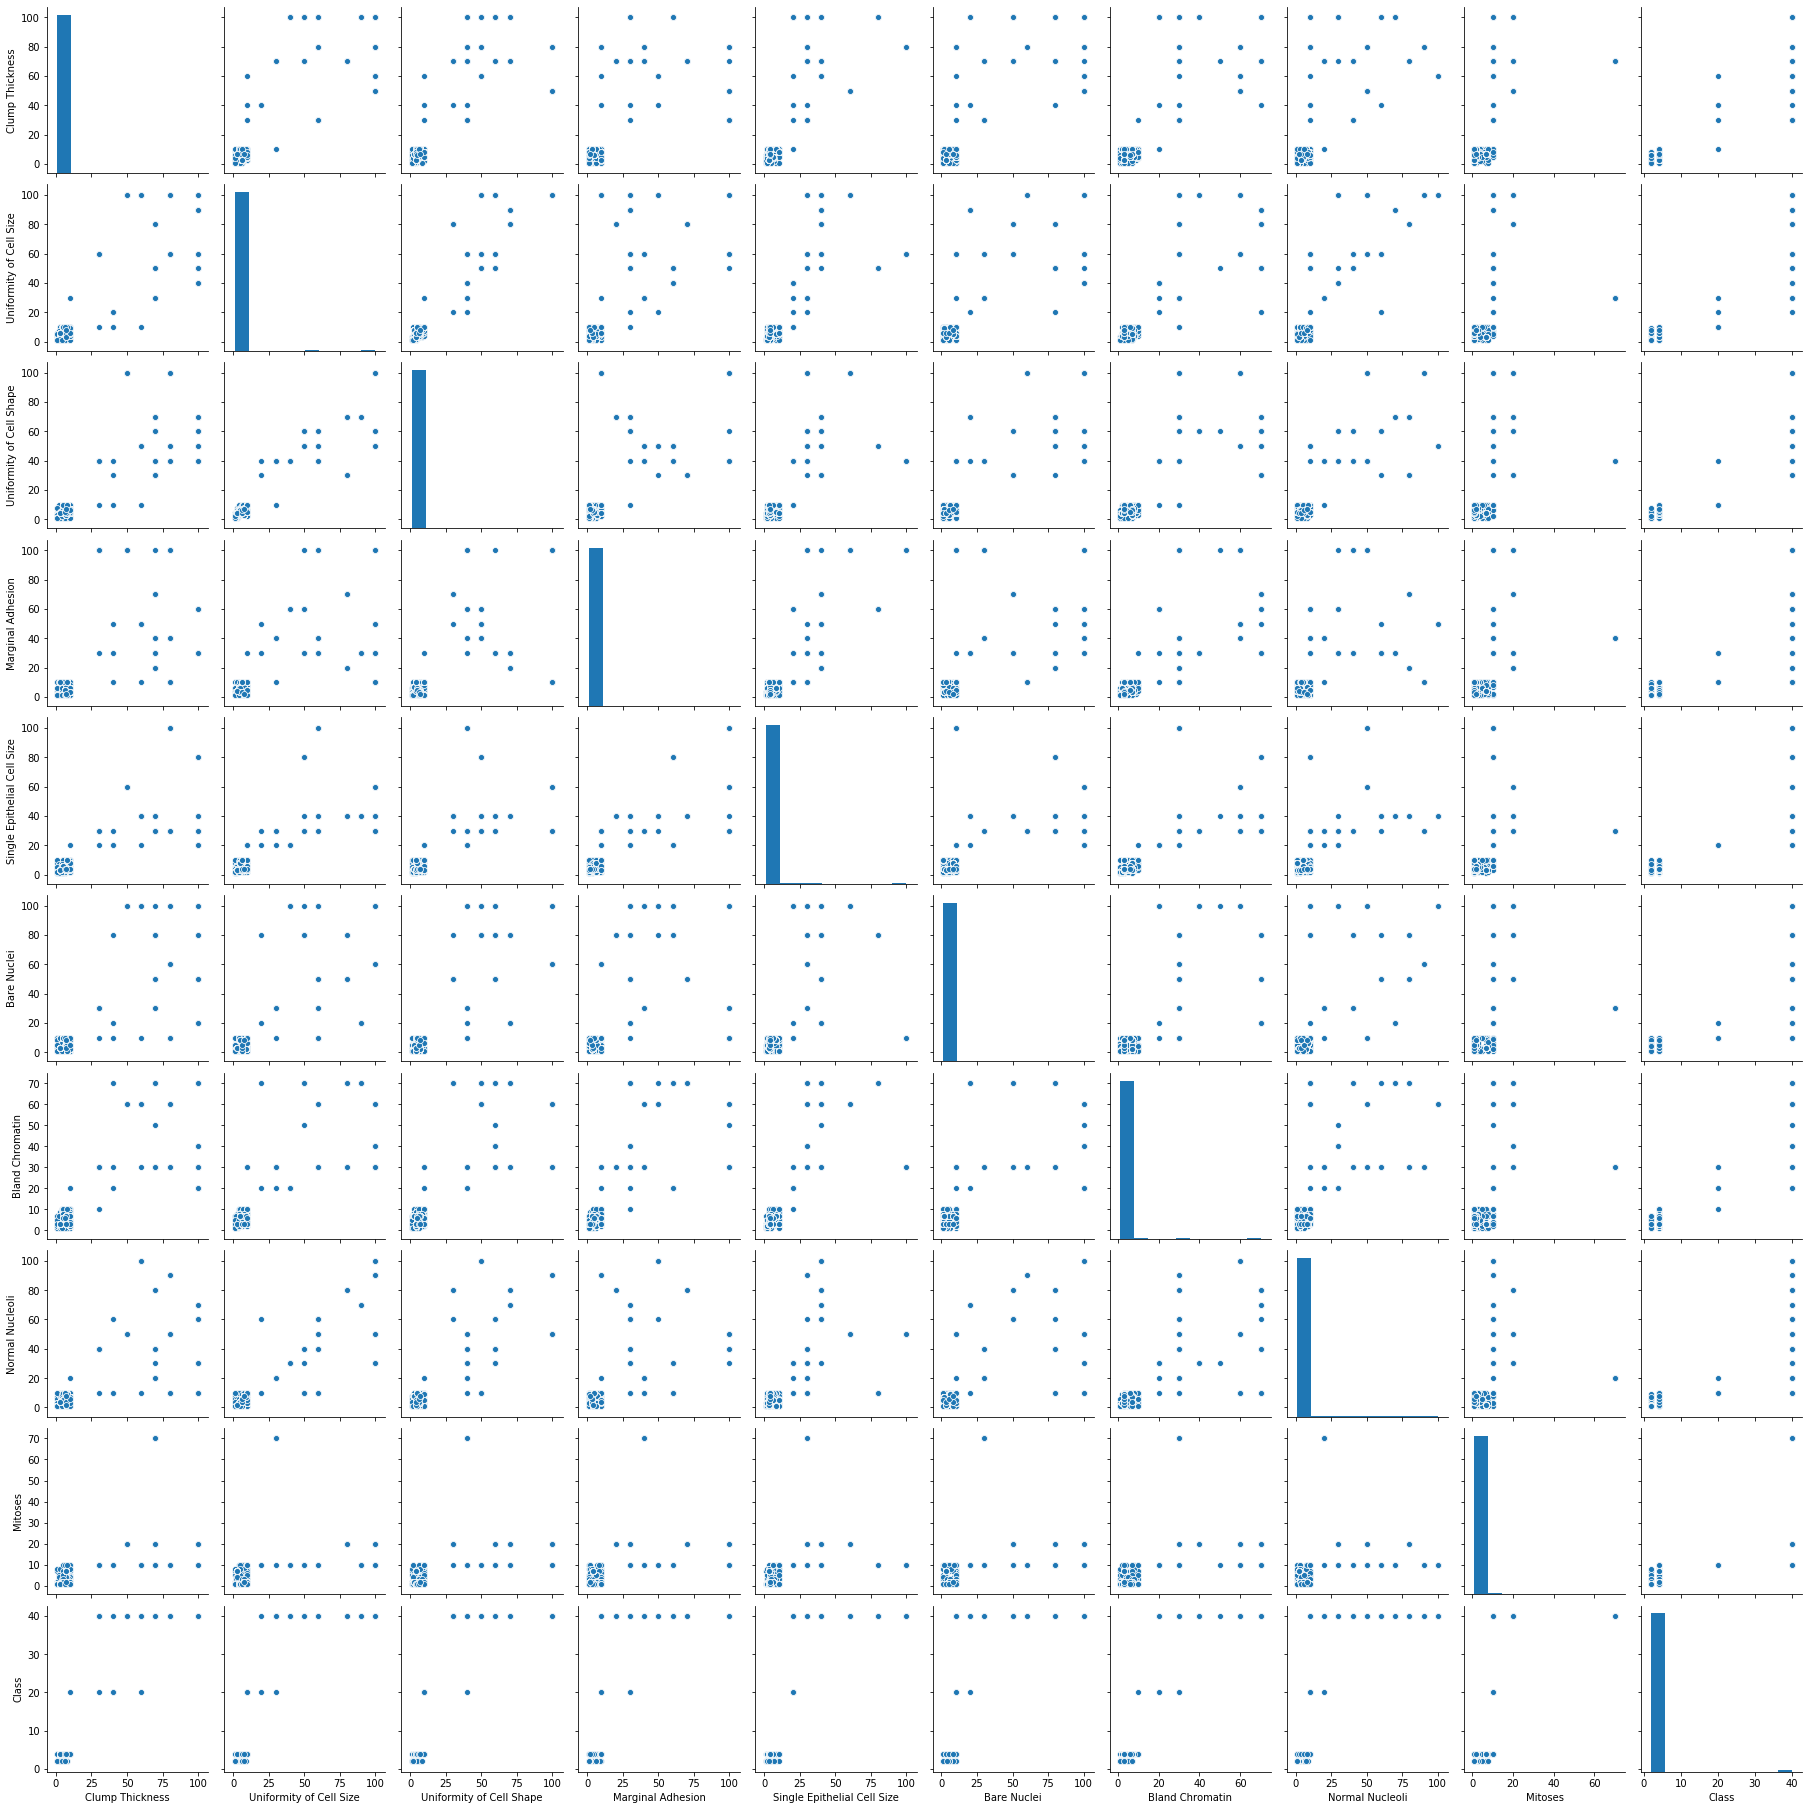

In [100]:
sns.pairplot(df.iloc[:,1:11])

The values higher than 10 appear to be values from 1-10 multiplied by ten, suggesting that these are incorrect inputs. It may be reasonable to assume that these values are input mistakes where the actual value is a factor of ten lower e.g. 30 -> 3, especially considering the categorical variables are multiplied by this factor. But since we do not know the origin of this input "mistake", and since the value of 10 may overlap with actual values of 1-10, we should exclude these samples. After finding out that samples containing above ten values are in the minority, we can exclude them from the dataset.

In [6]:
indices= df[df.iloc[:,1:11].values>10].index
dropped= df.drop(indices)
print(dropped.shape)
dropped.head()

(15698, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4


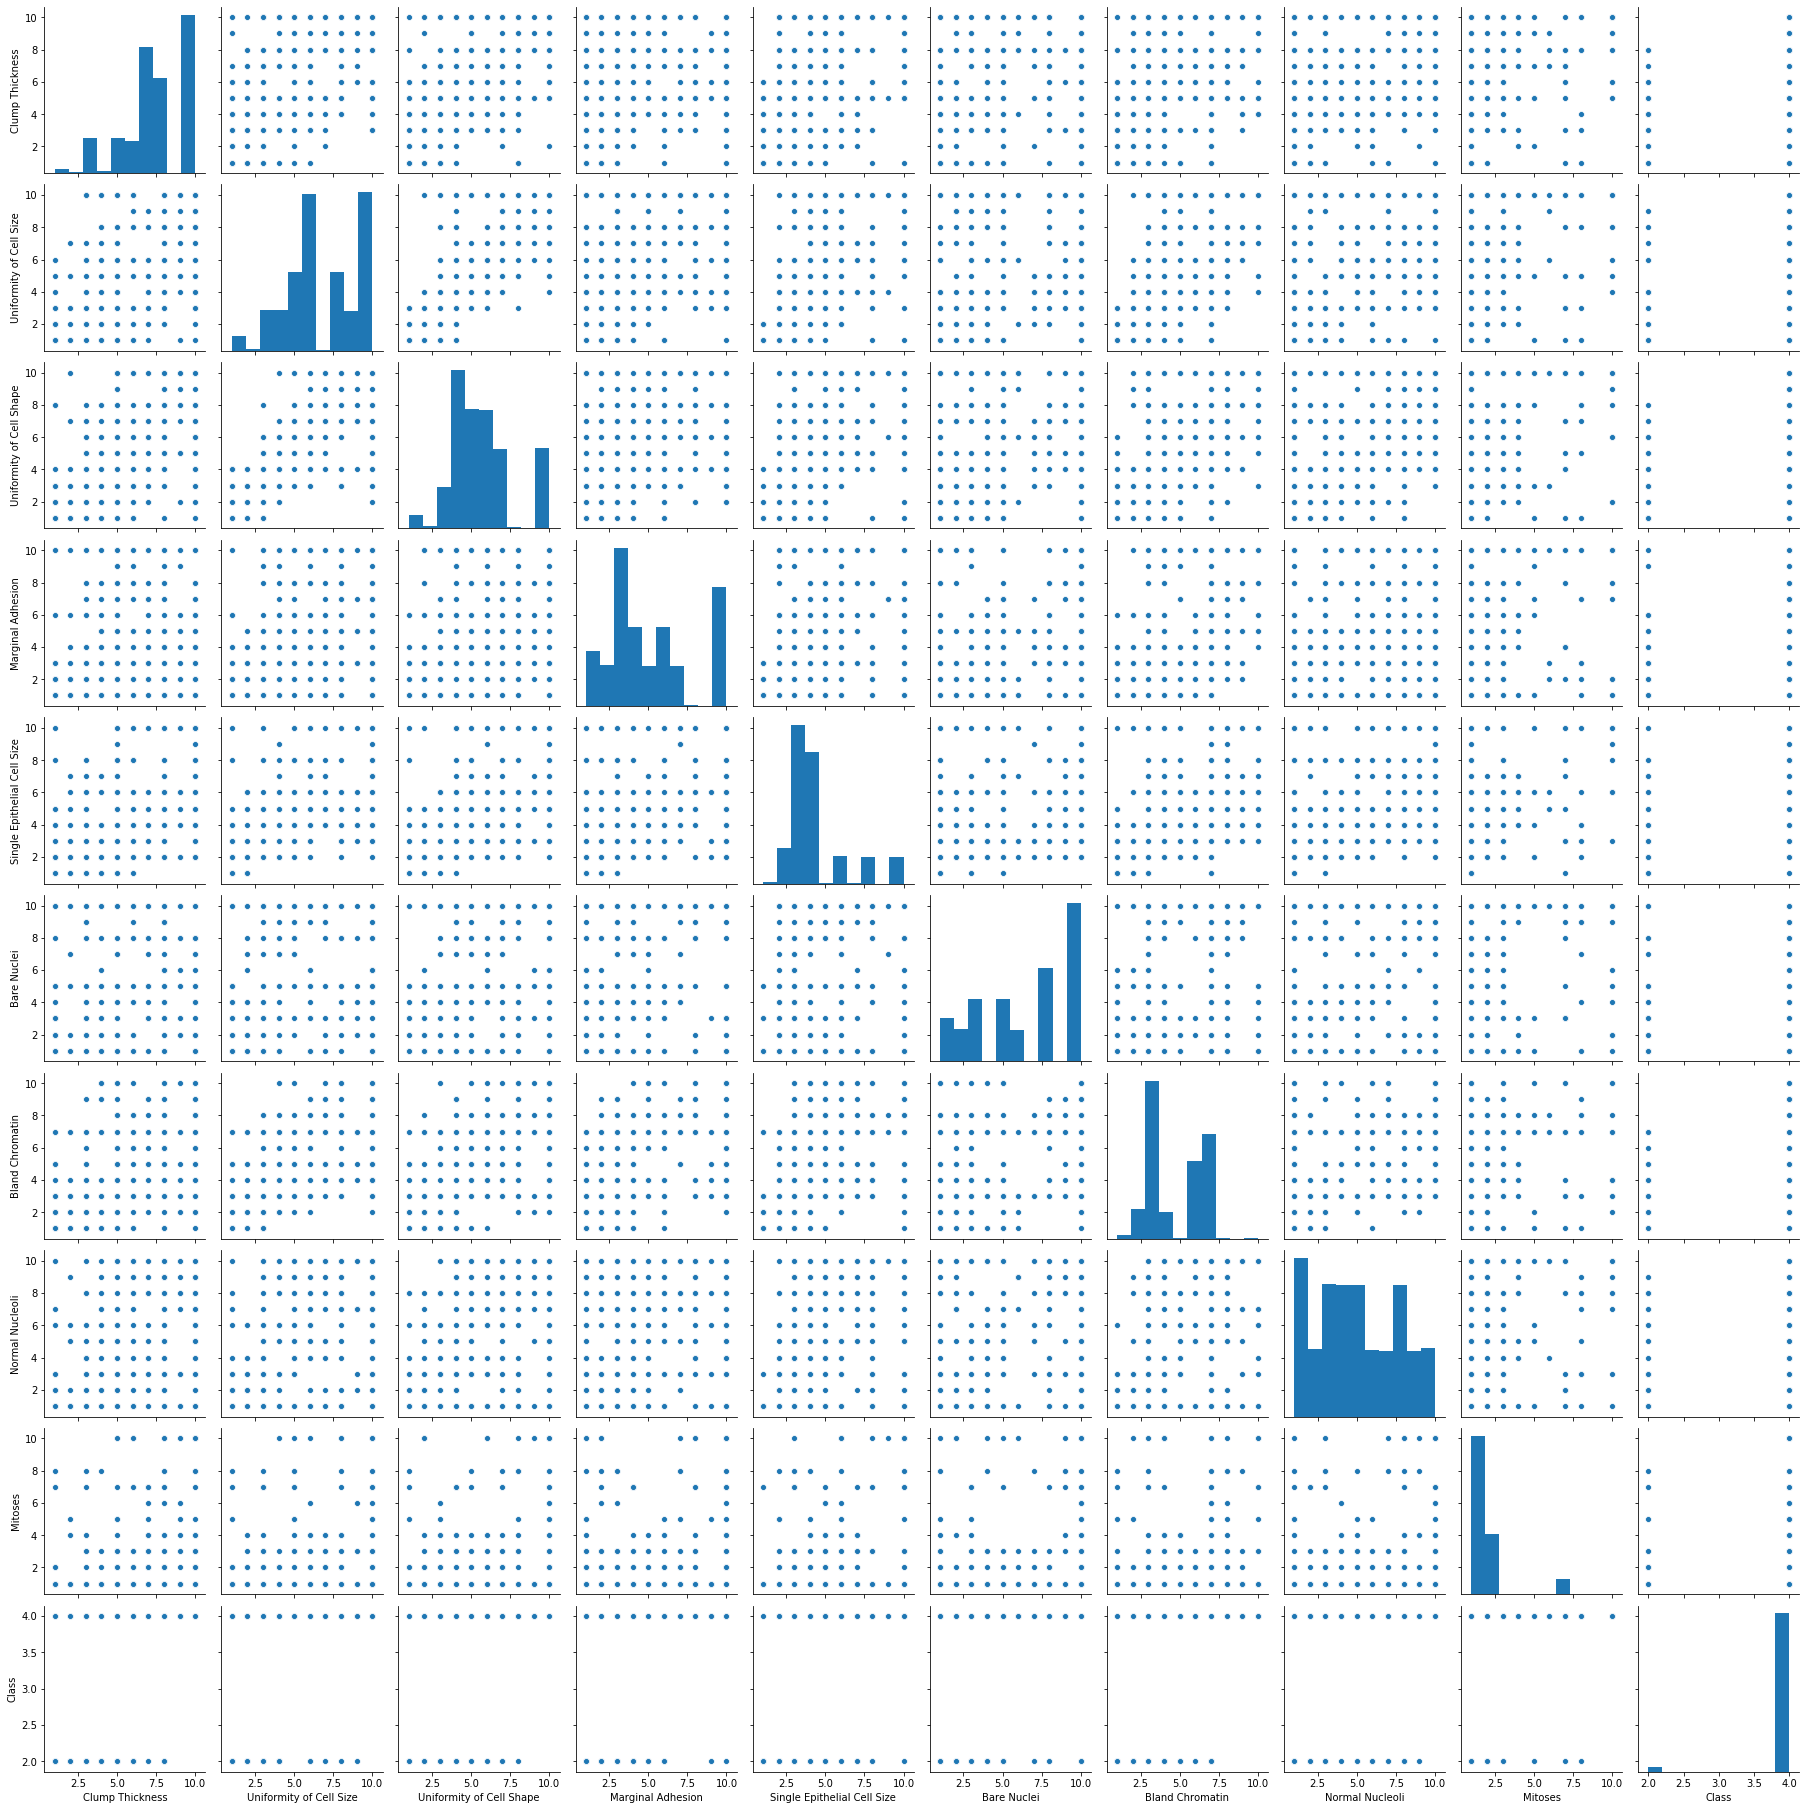

In [158]:
sns.pairplot(dropped.iloc[:,1:11], hue='Class')

The pairplot doesn't immediately reveal many correlations, or clusters, except between Uniformity of Cell Size and Uniformity of Cell Shape. We can also note that this is a strongly imbalanced data set, since there are substantially fewer samples in the benign class (minority class). Now to handle the <NA> values. Since we don't want to lose much more data, we can impute the values for cells containing null values. But since we are lazy, and it is very late, we are just going to replace <NA> values with the rounded mean. Science!

In [16]:
means= round(dropped.iloc[:,1:11].mean())
print(means)

Clump Thickness                8.0
Uniformity of Cell Size        7.0
Uniformity of Cell Shape       6.0
Marginal Adhesion              5.0
Single Epithelial Cell Size    4.0
Bare Nuclei                    6.0
Bland Chromatin                5.0
Normal Nucleoli                5.0
Mitoses                        2.0
Class                          4.0
dtype: float64


In [35]:
dropped.fillna(means)


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4
...,...,...,...,...,...,...,...,...,...,...,...
15850,1169049,7,3,4,4,3,3,3,2,7,4
15851,1076352,3,6,4,10,3,3,3,4,1,4
15852,1107684,6,10,5,5,4,10,6,10,1,4


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


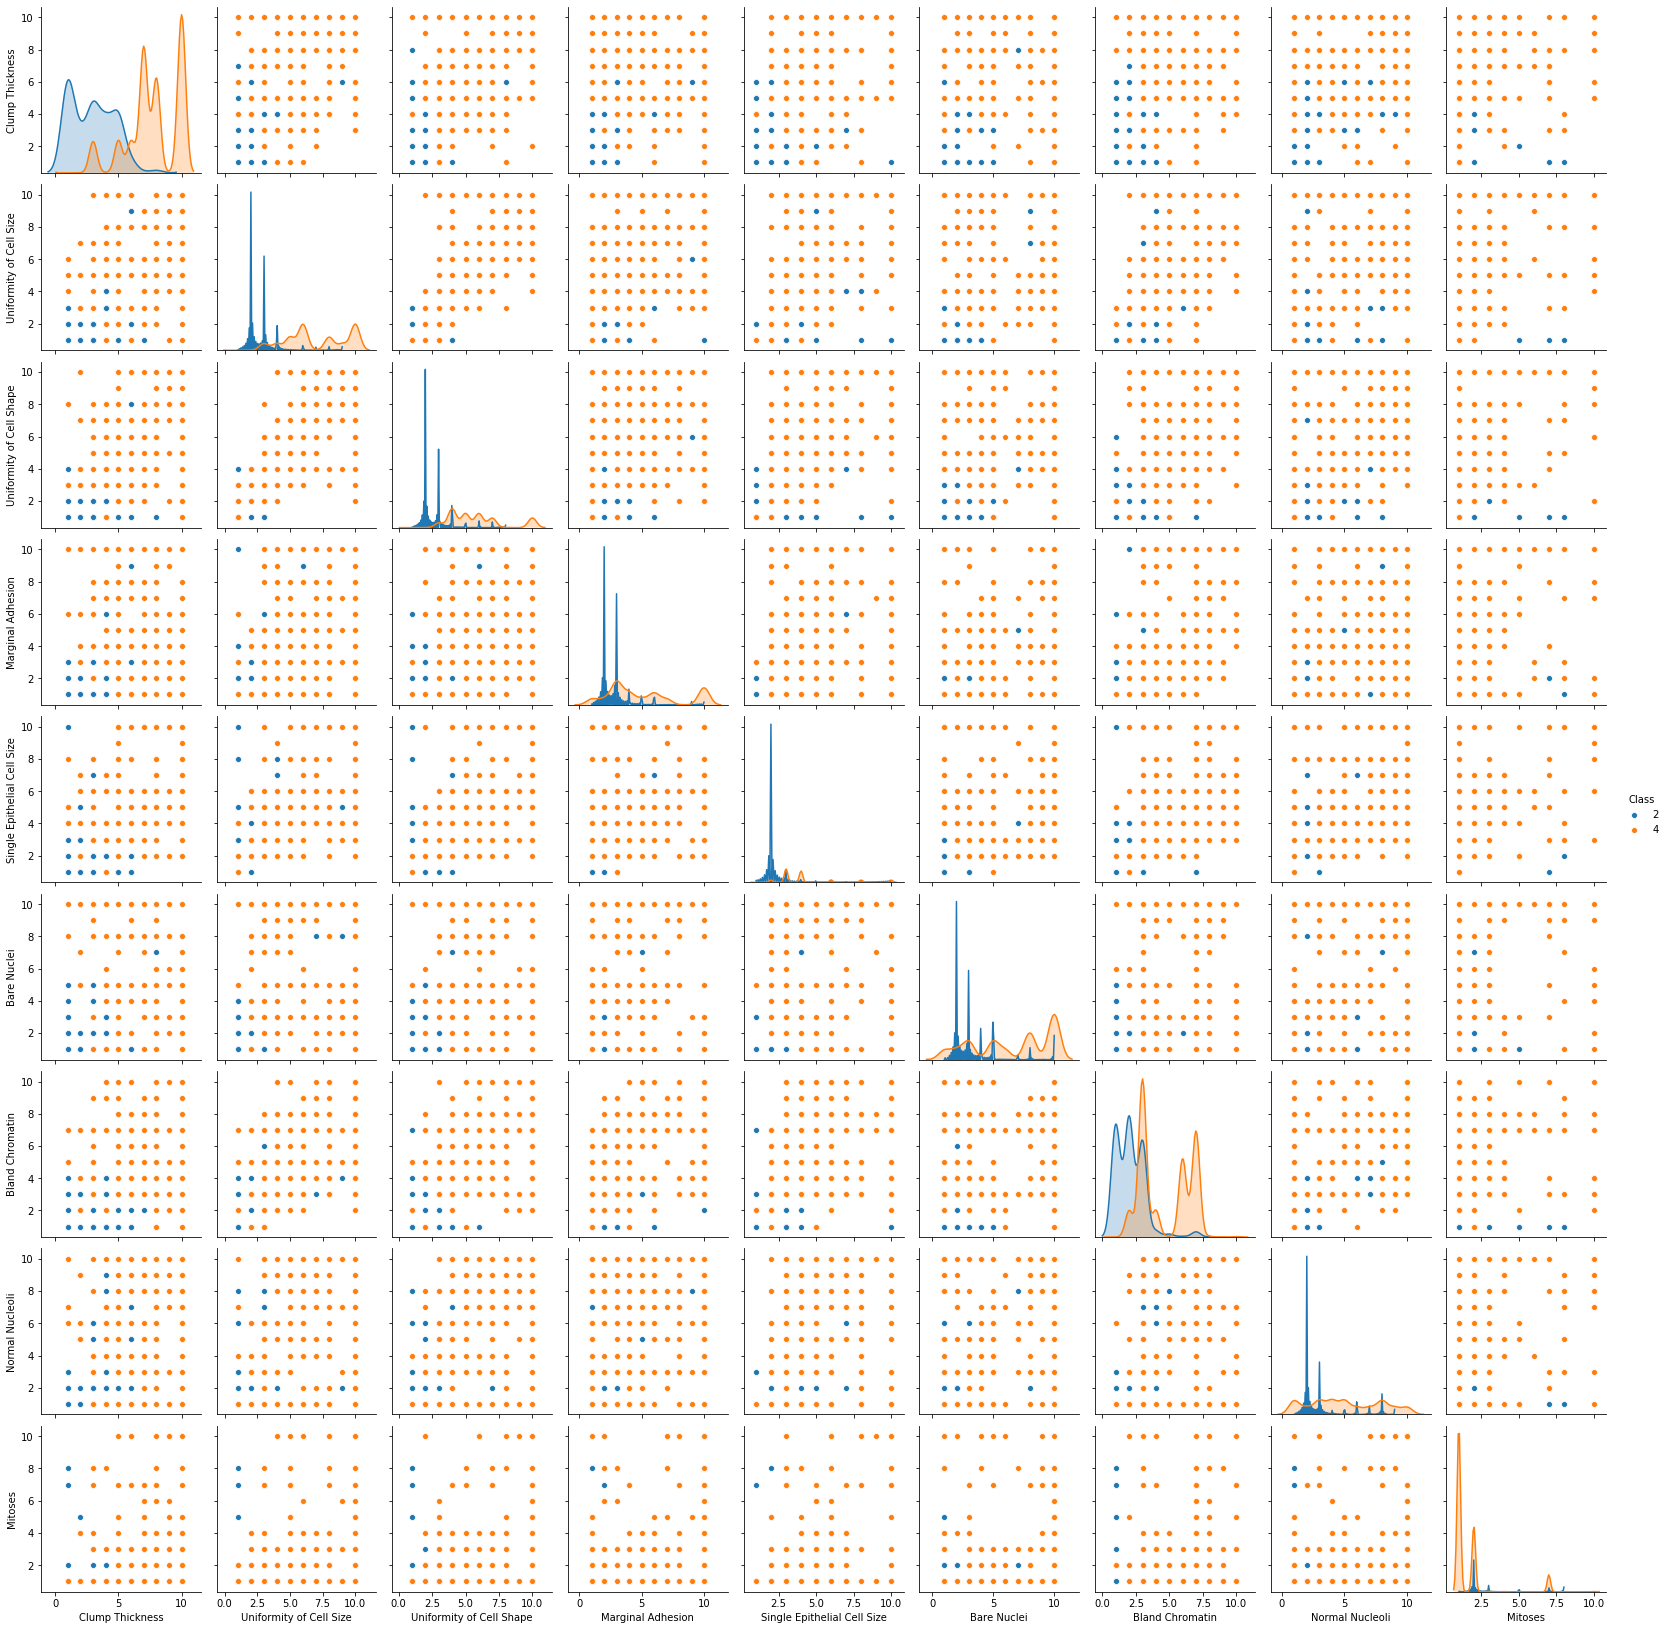

In [24]:
sns.pairplot(dropped.iloc[:,1:11], hue='Class')

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

train_features, test_features, train_labels, test_labels = train_test_split(dropped.iloc[:,1:10], dropped['Class'], test_size = 0.25, random_state = 42, stratify=dropped['Class'])
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

ValueError: ignored